In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *


In [2]:
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  np.loadtxt('data/%s_matrix.csv.gz' % dataset).astype(int)[::9, :]

In [3]:
observables = ['fi', 'fij', 'cij', 'fijk', 'cijk', 'fold_ijk']#, 'fijkl']
observables_dict = {key: dict() for key in observables}
for dataset in ['train', 'test', 'model']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

In [4]:
fi = observables_dict['fi']['train'].mean(axis=0)
sample_matrices['independent'] = np.random.choice(np.arange(0, 20, 1), size=sample_matrices['test'].shape, p=fi)

In [5]:
sample_matrices['flat'] = np.random.choice(np.arange(0, 20, 1), size=sample_matrices['test'].shape)

In [6]:
@jit(nopython=True)
def dist_jit(seqa, seqb):
    return np.sum(seqa != seqb)

In [7]:
nsample = 1e8
hists_dict = {}
bins = np.arange(0, 11, 1)
for dataset in ['test', 'model', 'independent', 'flat']:
    distances = pairwise_distances(sample_matrices[dataset], N=nsample, distance=dist_jit)
    hist, _ = np.histogram(distances, bins=bins-0.5)
    hists_dict[dataset] = hist

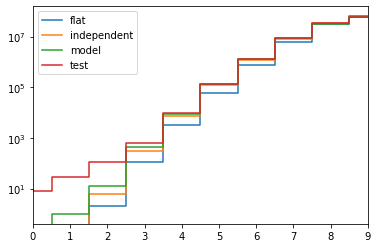

In [8]:
fig, ax = plt.subplots()
for dataset in ['flat', 'independent', 'model', 'test']:
    ax.step(bins[:-1], hists_dict[dataset], label=dataset, where='mid')
ax.set_yscale('log')
ax.set_xticks(bins)
ax.set_xlim(bins[0], bins[-2])
ax.legend(loc='upper left');

In [9]:
kmers = np.array([list(kmer) for kmer in
                  to_kmers(pd.read_csv('../pfam/data/human_nozf.csv', index_col=0)['seq'], 9)])
filtered = map_matrix(kmers, map_)[::9]

In [10]:
distances = pairwise_distances(filtered, N=nsample, distance=dist_jit)
hist, _ = np.histogram(distances, bins=bins-0.5)
hists_dict['filtered'] = hist

In [11]:
distances = pairwise_distances(sample_matrices['train'], data2=sample_matrices['test'],
                               N=nsample, distance=dist_jit)
hist, _ = np.histogram(distances, bins=bins-0.5)
hists_dict['train_test'] = hist

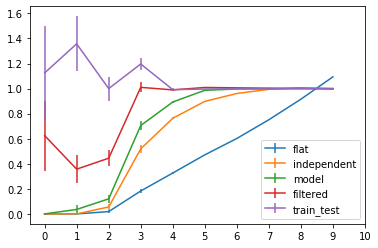

In [12]:
fig, ax = plt.subplots()
for dataset in ['flat', 'independent', 'model', 'filtered', 'train_test']:
    ax.errorbar(bins[:-1], hists_dict[dataset]/hists_dict['test'],
                hists_dict[dataset]**.5/hists_dict['test'],
                label=dataset)
ax.set_xticks(bins);
ax.legend(loc='lower right')

In [ ]:
pairwise_dist = {}
for dataset in ['model', 'independent', 'flat']:
    pairwise_dist[dataset] = pairwise_distances(sample_matrices[dataset],
                                                data2=sample_matrices['test'],
                                                N=nsample, distance=dist_jit)

In [ ]:
fig, ax = plt.subplots()
bins = np.arange(1, 11, 1)
ax.hist(distances_dict['filtered'], histtype='step', label='within', bins=bins-0.5)
for dataset in ['flat', 'independent', 'model']:
    ax.hist(pairwise_dist[dataset], histtype='step', label=dataset, bins=bins-0.5)
ax.set_yscale('log')
ax.set_xticks(bins);
ax.legend(loc='upper left')